# Final Notebook
# By Nodar Sotkilava
## Sources:
https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
https://keras.io/examples/vision/grad_cam/
https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

### Note:

Some of the final values might have changes because I re-ran the notebook.


In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras.backend as K
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split 
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
es = EarlyStopping(monitor="val_loss",patience=5)
def cnn_V2_IDC():
    model2 = models.Sequential()
    model2.add(Conv2D(124, (5, 5), (2, 2), padding="same", input_shape=(50, 50, 3),activation="relu"))
    model2.add(Dropout(0.4))
    model2.add(Conv2D(248, (5, 5), strides=(2, 2), padding="same", input_shape=(50, 50, 3), activation="relu", name='conv_layer_42_IDC'))
    model2.add(Flatten())
    model2.add(Dense(2, activation="softmax"))

    model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer="adam", metrics=["accuracy"])

    return model2

def cnn_V2_XRAY():
    model2 = models.Sequential()
    model2.add(Conv2D(124, (5, 5), (2, 2), padding="same", input_shape=(256, 256, 3),activation="relu"))
    model2.add(Dropout(0.4))
    model2.add(Conv2D(248, (5, 5), strides=(2, 2), padding="same", input_shape=(256, 256, 3), activation="relu", name='conv_layer_42_XRAY'))
    model2.add(Flatten())
    model2.add(Dense(1, activation="sigmoid"))

    model2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

    return model2
# def mega_CNN_XRAY():
#     model = VGG16(weights=None)
#     model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer="adam")
#     return model

In [3]:
model = cnn_V2_IDC()
model.summary()
model2 = cnn_V2_XRAY()
model2.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 124)       9424      
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 124)       0         
_________________________________________________________________
conv_layer_42_IDC (Conv2D)   (None, 13, 13, 248)       769048    
_________________________________________________________________
flatten (Flatten)            (None, 41912)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 83826     
Total params: 862,298
Trainable params: 862,298
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
__________________

In [4]:
def prepare_IDC_data(visualize=False):
    # Load data. X data and Y labels
    x_images = np.load("images/X.npy")
    y_images = np.load("images/Y.npy")
    
    if visualize:
        print(x_images.shape)
        print(y_images.shape)

        plt.imshow(x_images[0])
        plt.title(y_images[0])
    
    train_images, test_images, train_labels, test_labels = train_test_split(x_images, y_images, test_size=0.20)

    # Normalize pixel values to be between 0 and 1
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    train_labels = np_utils.to_categorical(train_labels)
    test_labels = np_utils.to_categorical(test_labels)

    return train_images, test_images, train_labels, test_labels

In [5]:
def prepare_XRAY_data(visualize=False, size=(256,256)):
    train_ds = image_dataset_from_directory("chest_xray/train", image_size=size)
    val_ds = image_dataset_from_directory("chest_xray/val", image_size=size)
    test_ds = image_dataset_from_directory("chest_xray/test", image_size=size)

    class_names = train_ds.class_names

    print(class_names)

    if visualize:
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]] + str(labels[i].numpy().astype("uint8")))
                plt.axis("off")

    #Normalize the images
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))   

    normalized_ds_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch_test, labels_batch_test = next(iter(normalized_ds_test))   

    normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch_val,labels_batch_val = next(iter(normalized_ds_val))

    return image_batch,labels_batch,image_batch_test,labels_batch_test,image_batch_val,labels_batch_val

In [6]:
def train_model_IDC(model,data):
    train_images, test_images, train_labels, test_labels = data()
    history = model.fit(train_images, train_labels, epochs=50, batch_size=128, validation_data=(test_images, test_labels), callbacks=[es])
    model.evaluate(test_images,test_labels)
    plt.figure(1)
    plt.plot(history.history["loss"], label = "Categorical loss")
    plt.plot(history.history["val_loss"], label = "Validation loss")
    plt.legend()
def train_model_XRAY(model,data,size):
    X,y,X_test,y_test,X_val,y_val = data(visualize = False, size = size)
    history = model.fit(X, y, epochs=50,validation_data=(X_val, y_val),callbacks=[es])
    model.evaluate(X_test,y_test)
    plt.plot(history.history["loss"], label = "Binary loss")
    plt.plot(history.history["val_loss"], label = "Validation loss")
    plt.legend()

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


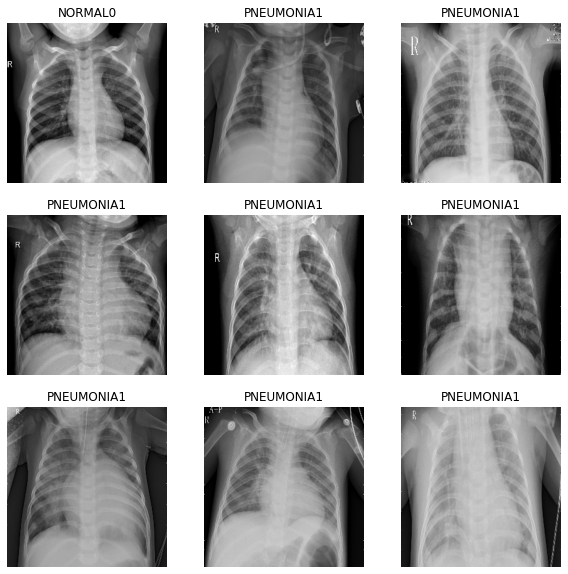

In [7]:
X,y,X_test,y_test,X_val,y_val = prepare_XRAY_data(visualize = True, size = (256,256))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.6380 - accuracy: 0.8125 - val_loss: 35.6822 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 11.5625 - accuracy: 0.8438 - val_loss: 7.4999 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 2.5299 - accuracy: 0.8438 - val_loss: 0.8776 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.4136 - accuracy: 0.8438 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 0.6319 - accuracy: 0.8438 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 0.6566 - accuracy: 0.8438 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 7/50
1/1 [================

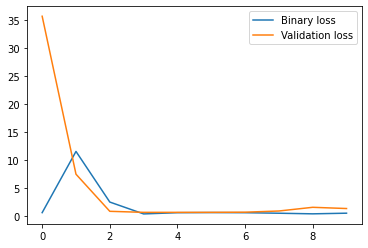

In [8]:
train_model_XRAY(model2,prepare_XRAY_data,(256,256))

(5547, 50, 50, 3)
(5547,)


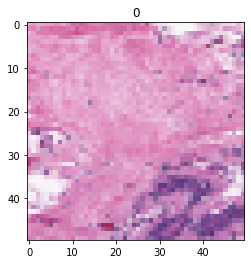

In [9]:
train_images, test_images, train_labels, test_labels = prepare_IDC_data(visualize=True)

Epoch 1/50
35/35 [==============================] - 13s 364ms/step - loss: 0.7205 - accuracy: 0.5161 - val_loss: 0.6819 - val_accuracy: 0.5856
Epoch 2/50
35/35 [==============================] - 13s 364ms/step - loss: 0.6456 - accuracy: 0.6380 - val_loss: 0.6238 - val_accuracy: 0.6333
Epoch 3/50
35/35 [==============================] - 13s 358ms/step - loss: 0.5905 - accuracy: 0.6951 - val_loss: 0.6581 - val_accuracy: 0.6018
Epoch 4/50
35/35 [==============================] - 13s 359ms/step - loss: 0.5634 - accuracy: 0.7228 - val_loss: 0.6439 - val_accuracy: 0.6378
Epoch 5/50
35/35 [==============================] - 13s 372ms/step - loss: 0.5555 - accuracy: 0.7277 - val_loss: 0.5526 - val_accuracy: 0.7288
Epoch 6/50
35/35 [==============================] - 13s 361ms/step - loss: 0.5319 - accuracy: 0.7505 - val_loss: 0.6826 - val_accuracy: 0.6559
Epoch 7/50
35/35 [==============================] - 13s 366ms/step - loss: 0.5467 - accuracy: 0.7424 - val_loss: 0.5509 - val_accuracy: 0.7288

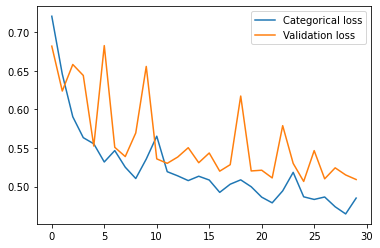

In [10]:

train_model_IDC(model, prepare_IDC_data)

In [24]:
img = image.load_img("chest_xray/test/NORMAL/NORMAL2-IM-0352-0001.jpeg", target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

img2 = image.load_img("chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg", target_size=(256, 256))
x2 = image.img_to_array(img2)
x2 = np.expand_dims(x2, axis=0)
x2 = x2 / 255.0

img3 = image.load_img('test_images/idctest.jpeg', target_size=(50,50))
x3 = image.img_to_array(img3)
x3 = np.expand_dims(x3,axis=0)
x3 = x3 /255.0

In [25]:
model_out = model2.predict(x)
model_out2 = model2.predict(x2)
model_out3 = model.predict(x3)
print(model_out)
print(model_out2)
print(model_out3)

[[0.93525827]]
[[0.9206934]]
[[0.25133625 0.7486637 ]]


In [27]:
with tf.GradientTape() as tape:
    last_conv_layer = model2.get_layer('conv_layer_42_XRAY')
    iterate = tf.keras.models.Model([model2.inputs],
                                        [model2.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [29]:
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer),axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((64, 64))

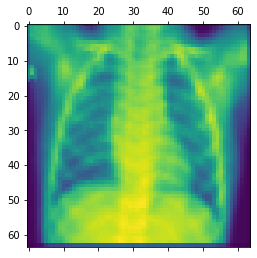

In [30]:
plt.matshow(heatmap)
plt.show()

In [31]:
def adjust_gamma(image, gamma=1.0):
   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [32]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [33]:
img = cv2.imread("chest_xray/test/NORMAL/NORMAL2-IM-0352-0001.jpeg")

# Grey scale and change gamma
#img = adjust_gamma(img, gamma=0.25)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = np.expand_dims(img, axis=2)
#img = increase_brightness(img,value=-20)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#Change gamma of the heatmap
#heatmap = adjust_gamma(heatmap, gamma=1)
#heatmap = increase_brightness(heatmap, value=-100)

hif = 0.5
superimposed_img = heatmap * hif + img

In [34]:
output = 'XRAYOutput.jpeg'
cv2.imwrite(output, superimposed_img)

True